In [1]:
%load_ext autoreload
%autoreload 2
from glob import glob
import os
from pathlib import Path
import re
import sys
import yaml
import datetime
import numpy as np
import pandas as pd
from tqdm import tqdm
from func.utils import get_categorical_features, read_pkl_gzip, to_pkl_gzip, parallel_load_data, get_filename, logger_func
from ieee_train import eval_train, eval_check_feature
from kaggle_utils import reduce_mem_usage, move_feature
logger = logger_func()

2019-09-16 12:14:17,018 func.utils 347 [INFO]    [logger_func] start 


In [2]:
COLUMN_ID = 'TransactionID'
COLUMN_DT = 'TransactionDT'
COLUMN_TARGET = 'isFraud'
COLUMN_GROUP = 'DT-M'
COLUMNS_IGNORE = [COLUMN_ID, COLUMN_DT, COLUMN_TARGET, COLUMN_GROUP, 'is_train', 'date']

def filter_feature(path):
    if path.count(''):
        return True
    else:
        return False

paths_train = glob('../feature/raw_use/*_train.gz')
paths_train = [path for path in paths_train if filter_feature(path) ]
paths_test = glob('../feature/raw_use/*_test.gz')
paths_test = [path for path in paths_test if filter_feature(path) ]

paths_train_feature = sorted(glob('../feature/org_use/*_train.gz'))
paths_test_feature  = sorted(glob('../feature/org_use/*_test.gz'))

# paths_train_feature += sorted(glob('../feature/valid/*_train.gz'))
# paths_test_feature  += sorted(glob('../feature/valid/*_test.gz'))

# paths_train_feature += sorted(glob('../feature/kernel/*_train.gz'))
# paths_test_feature  += sorted(glob('../feature/kernel/*_test.gz'))

paths_train_feature += sorted(glob('../feature/valid_use/*_train.gz'))
paths_test_feature  += sorted(glob('../feature/valid_use/*_test.gz'))

# df_train = reduce_mem_usage( parallel_load_data(paths_train) )
# df_test  = reduce_mem_usage( parallel_load_data(paths_test) )
df_train = parallel_load_data(paths_train)
df_test  = parallel_load_data(paths_test)
Y = df_train[COLUMN_TARGET]
df_train.drop(COLUMN_TARGET, axis=1, inplace=True)

  2%|▏         | 2/129 [00:00<00:08, 15.04it/s]

* Check Unique Feature.


100%|██████████| 129/129 [00:13<00:00,  6.60it/s]


All Features have info.
  * Diff Features: 0
Training until validation scores don't improve for 50 rounds.
[200]	valid_0's auc: 0.923898
Early stopping, best iteration is:
[260]	valid_0's auc: 0.925864


2019-09-16 12:15:23,340 func.utils 111 [INFO]    [ieee_cv]   * Fold0 2017-12: 0.9258638871615548 


[  * Fold0 Validation-DT-M 2017-12: 134339] done in 35 s
Training until validation scores don't improve for 50 rounds.
[200]	valid_0's auc: 0.946481
Early stopping, best iteration is:
[281]	valid_0's auc: 0.94707


2019-09-16 12:15:56,337 func.utils 111 [INFO]    [ieee_cv]   * Fold1 2018-3: 0.9470695644943145 


[  * Fold1 Validation-DT-M 2018-3: 101968] done in 32 s
Training until validation scores don't improve for 50 rounds.
[200]	valid_0's auc: 0.949338
Early stopping, best iteration is:
[243]	valid_0's auc: 0.950095


2019-09-16 12:16:26,595 func.utils 111 [INFO]    [ieee_cv]   * Fold2 2018-1: 0.9500945504081847 


[  * Fold2 Validation-DT-M 2018-1: 92510] done in 29 s
Training until validation scores don't improve for 50 rounds.
[200]	valid_0's auc: 0.946689
Early stopping, best iteration is:
[282]	valid_0's auc: 0.947795


2019-09-16 12:16:58,731 func.utils 111 [INFO]    [ieee_cv]   * Fold3 2018-5: 0.9477953816688572 


[  * Fold3 Validation-DT-M 2018-5: 92427] done in 31 s
Training until validation scores don't improve for 50 rounds.
[200]	valid_0's auc: 0.954521
[400]	valid_0's auc: 0.955621
Early stopping, best iteration is:
[398]	valid_0's auc: 0.955692


2019-09-16 12:17:39,880 func.utils 111 [INFO]    [ieee_cv]   * Fold4 2018-2: 0.9556923734314983 


[  * Fold4 Validation-DT-M 2018-2: 85725] done in 40 s
Training until validation scores don't improve for 50 rounds.
[200]	valid_0's auc: 0.959382
Early stopping, best iteration is:
[306]	valid_0's auc: 0.959848


2019-09-16 12:18:14,640 func.utils 111 [INFO]    [ieee_cv]   * Fold5 2018-4: 0.9598475450528429 


[  * Fold5 Validation-DT-M 2018-4: 83571] done in 34 s
[  * Make Prediction Result File.] done in 49 s
* Check Corr with Past Submit.
  *  (506691,) (506691,)
  * LB0.9516 / 0.9064152557829043
  *  (506691,) (506691,)
  * LB0.95169 / 0.9555742339046125
  *  (506691,) (506691,)
  * LB0.9518 / 0.956863746096553
  *  (506691,) (506691,)
  * LB0.9529 / 0.9480095053374643
  *  (506691,) (506691,)
  * LB0.9542 / 0.8882596507030079
* CV: 0.9477272170362087 | BestIter: 295.0
* Training Feature Importance


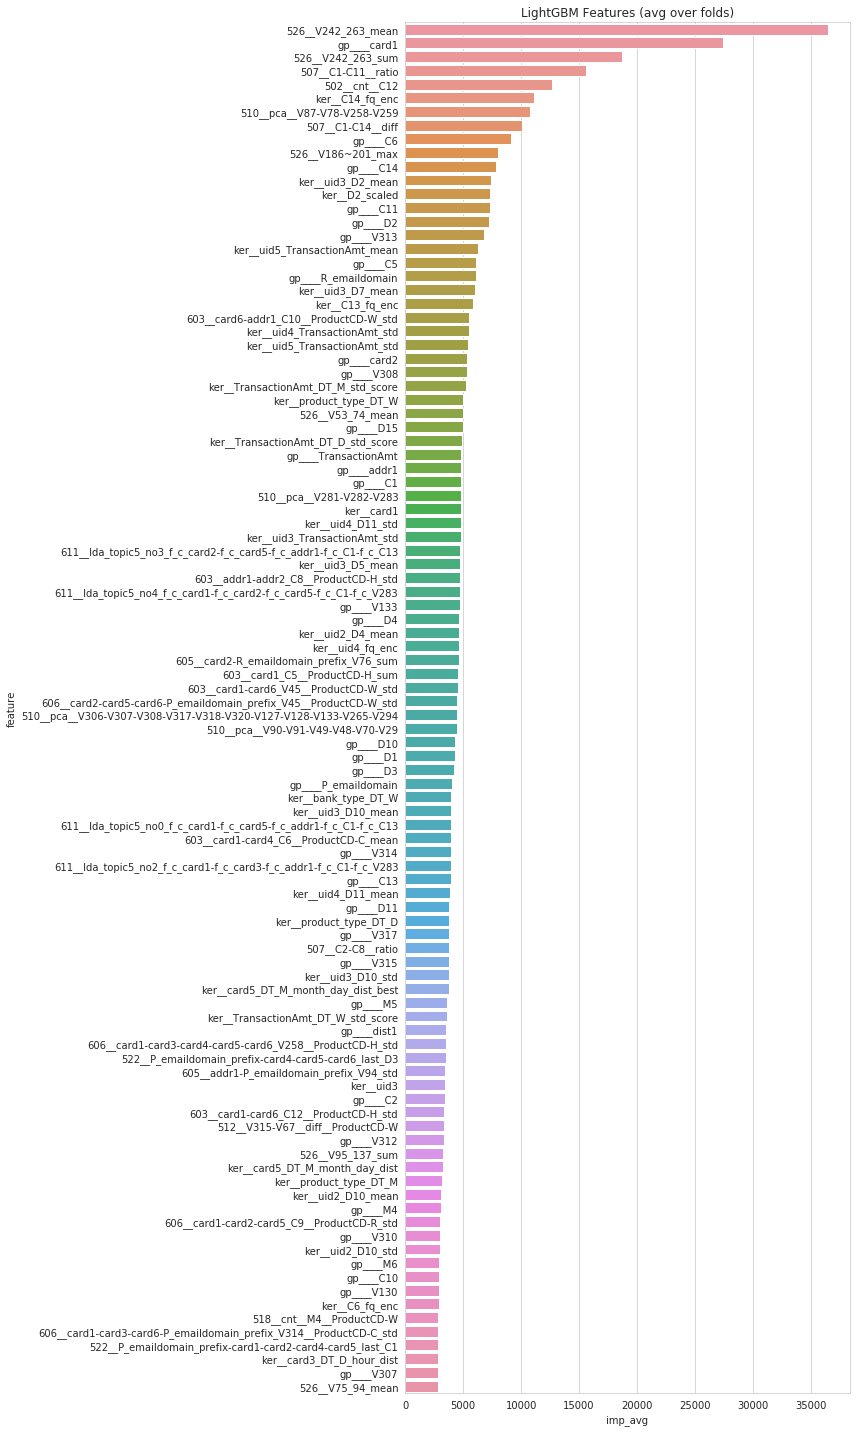

Setup Dataset dim_ml_dataset.


In [3]:
is_submit = [True, False][1]
valid_paths_train = paths_train_feature[:]
valid_paths_test  = paths_test_feature[:]

#========================================================================
# pathの存在チェック。なぜかたびたびFileNotFoundErrorが起きるので,,,
#========================================================================
remove_paths = []
for trn_path, tes_path in zip(valid_paths_train, valid_paths_test):
    if os.path.exists(trn_path) and os.path.exists(tes_path):
        pass
    else:
        remove_paths.append(trn_path)
        remove_paths.append(tes_path)
for path in remove_paths:
    if path.count('train'):
        valid_paths_train.remove(path)
        print(f'remove {path}')
    elif path.count('test'):
        valid_paths_test.remove(path)
        print(f'remove {path}')

df_feat_train = parallel_load_data(valid_paths_train)
df_feat_test  = parallel_load_data(valid_paths_test)

col_drops = eval_check_feature(df_feat_train, df_feat_test)

tmp_train = df_train.join(df_feat_train)
tmp_test = df_test.join(df_feat_test)
# tmp_train = df_train
# tmp_test = df_test

#========================================================================
# Train Test で片方に存在しないFeatureを除外
#========================================================================
diff_cols = list(set(tmp_train.columns) - set(tmp_test.columns))

for col in list(set(diff_cols)):
    from_dir = 'valid'
    to_dir = 'valid_trush'
    move_feature([col], from_dir, to_dir)
tmp_train.drop(diff_cols, axis=1, inplace=True)
print(f"  * Diff Features: {len(diff_cols)}")

# same_user_path = '../output/same_user_pattern/20190901_user_ids_share.csv'
# same_user_path = '../output/same_user_pattern/0902__same_user_id__card_addr_pemail_M.csv'
group_kfold_path = '../input/0908_ieee__DT-M_GroupKFold.gz'
group = read_pkl_gzip(group_kfold_path)
tmp_train[COLUMN_GROUP] = group


#========================================================================
# Features elimination 
#==============================================================
# from scipy.stats import ks_2samp
# features_check = []
# columns_to_check = set(list(tmp_train)).difference(COLUMNS_IGNORE)
# for i in columns_to_check:
#     features_check.append(ks_2samp(tmp_test[i], tmp_train[i])[1])

# features_check = pd.Series(features_check, index=columns_to_check).sort_values() 
# features_discard = list(features_check[features_check==0].index)
# print(features_discard)
# tmp_train.drop(features_discard, axis=1, inplace=True)
# tmp_test.drop(features_discard, axis=1, inplace=True)


model_type = "lgb"
params = {
#     'n_jobs': 64,
    'n_jobs': 48,
#     'n_jobs': 32,
    'seed': 1208,
    'n_splits': 6,
    'metric': 'auc',
    'model_type': model_type,
    'objective': 'binary',
    'fold': ['stratified', 'group'][1],
    'num_leaves': 2**8-1,
    'max_depth': -1,
    'subsample': 0.9,
    'subsample_freq': 1,
    'colsample_bytree' : 0.30,
    'lambda_l1' : 0.1,
    'lambda_l2' : 1.0,
    'learning_rate' : 0.1,
    "early_stopping_rounds": 50,
}

if is_submit:
    params['learning_rate'] = 0.01
    params["early_stopping_rounds"] = 100

list_result_feim = eval_train(
    logger,
    tmp_train,
    Y,
    tmp_test,
    COLUMN_GROUP,
    model_type,
    params,
    is_adv=[True, False][1],
    is_viz=[True, False][0],
)

In [36]:
feim = list_result_feim[0]
list_uid = [f for f in feim.index if f.count('uid')]
feim.loc[list_uid]

,imp_fold1,imp_fold2,imp_fold3,imp_fold4,imp_fold5,imp_fold6,imp_avg
feature,,,,,,,
ker__uid3_D2_mean,9140.101562,6830.951660,6582.781738,7621.996094,6798.107422,7663.422852,7439.560059
ker__uid5_TransactionAmt_mean,6297.078125,6343.238770,6554.005371,6015.766602,5900.729980,6399.688965,6251.751465
ker__uid3_D7_mean,5945.617188,5649.524414,6047.096680,7103.138672,5953.987305,5608.286621,6051.274902
ker__uid4_TransactionAmt_std,5302.599609,5587.690918,4872.040527,5554.050293,5691.776367,5784.093750,5465.375488
ker__uid5_TransactionAmt_std,4994.430176,5255.998047,5134.803223,6050.168945,5445.870605,5694.800781,5429.345215
ker__uid4_D11_std,4817.644531,3989.696289,4566.628906,5374.601074,4959.444336,4994.002930,4783.669922
ker__uid3_TransactionAmt_std,4591.799805,3602.966064,4428.376953,5875.374512,5355.736328,4771.980957,4771.039062
ker__uid3_D5_mean,5092.366211,4537.372070,4492.854492,4655.606934,5040.930664,4580.245117,4733.229004
ker__uid2_D4_mean,4705.693359,4587.069824,4542.155273,4423.045410,4545.355469,5025.420410,4638.123535


In [33]:
sub = pd.read_csv('../submit/tmp/20190916_1214__CV0-9477272170362087__feature252.csv')
sub[COLUMN_ID] = sub[COLUMN_ID].astype('int')
sub.head()

,TransactionID,isFraud
0,3663549,0.000008
1,3663550,0.000178
2,3663551,0.000658
3,3663552,0.000010
4,3663553,0.000202


In [32]:
from sklearn.metrics import roc_auc_score
bear = pd.read_csv('../input/20190913_ieee__bear_probing.csv').iloc[:, [0, 4, 6]]
bear = bear[bear[COLUMN_TARGET]==-1]
bear = bear.iloc[:, [0,2]]
sub.columns = [COLUMN_ID, 'pred']
bear.columns = [COLUMN_ID, COLUMN_TARGET]
bear_score = sub.merge(bear, how='inner', on=COLUMN_ID)
roc_auc_score(bear_score[COLUMN_TARGET].values, bear_score['pred'].values)

0.9177659090009771

In [4]:
# feim = read_pkl_gzip('../output/feature_importances/20190912_0822__CV0-9456328818476605__feature726.gz')
# pd.set_option('max_rows', 200)
feim = list_result_feim[0]
# idx = [idx for idx in feim.index if idx.count('522_')]
# feim = feim.loc[idx]
feim.tail(100)
# feim.loc[[i for i in feim.index if i.count('browser')]]

,imp_fold1,imp_fold2,imp_fold3,imp_fold4,imp_fold5,imp_fold6,imp_avg
feature,,,,,,,
ker__C2_fq_enc,3747.883789,3851.317871,3856.016602,4166.633301,3901.173828,4360.776367,3980.633545
ker__card3_DT_D_hour_dist,2908.856934,4235.589844,4008.468506,4368.670410,3038.400146,5196.314941,3959.383545
517__cents__ProductCD-W,3999.681641,2930.601074,3731.733887,4637.179688,3390.208496,4411.786621,3850.198486
ker__C6_fq_enc,3487.891357,3498.899902,4113.752441,4010.236816,3104.831299,3967.906982,3697.252930
ker__C10_fq_enc,938.610107,1035.711670,6055.099121,6295.813965,3111.739502,3966.025146,3567.166748
603__card2-card5_C5__ProductCD-W_std,2691.301270,3494.937256,3378.628418,3597.624023,3549.942871,3815.729248,3421.360352
501__label__device_country__id_38,3423.976318,3929.998047,2200.971191,2497.901611,4054.841797,4245.608398,3392.216064
ker__uid3,3414.668945,2767.637451,3981.096680,3524.326416,3379.379883,3228.056885,3382.527588
606__card4-card5-card6-P_emaildomain_prefix_C1__ProductCD-C_std,3014.016357,2972.773193,4181.178223,3841.547119,2517.314453,3652.414795,3363.207031


In [9]:
# feim = read_pkl_gzip('../output/feature_importances/20190909_2324__CV0-9467296784440689__feature552.gz')
for feature_name in feim[feim['imp_avg']<50].index:
# for feature_name in feim.index:
#     if not feature_name.count('ker'):
#         continue

    if feature_name.count('raw'):
        from_dir = 'raw_use'
        to_dir = 'raw_trush'
#         from_dir = 'raw_trush'
#         to_dir = 'raw_use'
    else:
        from_dir = 'org_use'
        to_dir = 'org_trush'
#         from_dir = 'org_trush'
#         to_dir = 'org_use'
    from_dir = 'product_feature'
#     from_dir = 'kernel'
#     from_dir = 'check_trush'
#     from_dir = 'raw_trush'
#     from_dir = 'org_trush'
#     from_dir = 'useless'
    from_dir = 'valid_use'
    from_dir = 'org_use'
#     to_dir = 'valid_trush'
#     to_dir = 'check_trush'
#     to_dir = 'org_use'
    to_dir = 'useless'
#     to_dir = 'valid'
#     to_dir = 'kernel'
    try:
        print(feature_name)
        move_feature([feature_name], from_dir, to_dir)
    except FileNotFoundError:
        print(feature_name)

raw__R_emaildomain_mail_com_dummie
516__P_emaildomain_suffix_mx_dummie
516__R_emaildomain_suffix_es_dummie
516__R_emaildomain_suffix_us_dummie
516__P_emaildomain_suffix_es_dummie
516__R_emaildomain_suffix_fr_dummie
516__P_emaildomain_suffix_de_dummie
516__R_emaildomain_suffix_jp_dummie
516__P_emaildomain_suffix_fr_dummie
516__P_emaildomain_suffix_jp_dummie
516__R_emaildomain_suffix_uk_dummie
516__R_emaildomain_suffix_de_dummie
516__P_emaildomain_suffix_uk_dummie
